# WASP-39b NIRCam ExoIris analysis

**Author:** Hannu Parviainen </br>
**Edited:** 2025-08-08 </br>
**ExoIris version:** 0.19

This notebook carries out an ExoIris transmission spectroscopy analysis for the JWST NIRCam observations of WASP-39b reduced by [Carter et al. (2024)](https://www.nature.com/articles/s41550-024-02292-x). The original reduction and analysis of the observations was presented in [Ahrer et al. (2023)](https://www.nature.com/articles/s41586-022-05590-4).

**Note:** This notebook assumes you have already read the basic [ExoIris tutorials](https://exoiris.readthedocs.io/en/latest/examples/index.html).

In [1]:
%run ../setup_multiprocessing.py

In [2]:
from multiprocessing import Pool

from matplotlib.pyplot import subplots, setp, rc
from exoiris import ExoIris, TSData

rc('figure', figsize=(14, 4))

In [3]:
%run read_data.py
%run core.py

## Read the data

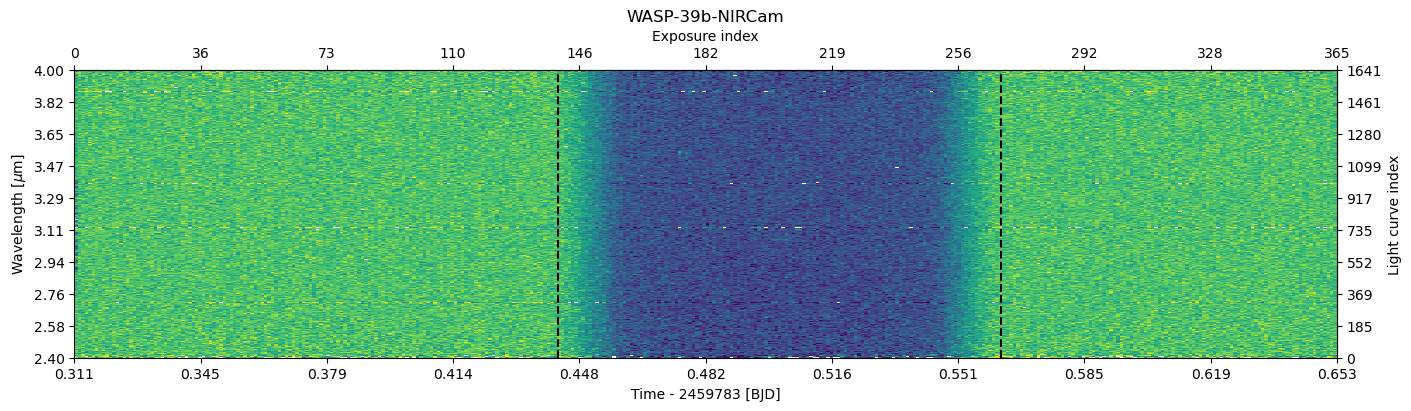

In [4]:
d = read_data('data/ZENODO/1_TIME_SERIES_SPECTRA/NIRCam_F322W2_Spectra.h5', 'WASP-39b-NIRCam', ephemeris=eph)
d.normalize_to_poly()
d.crop_wavelength(0.0, 4.0)
d.mask_outliers()
d.plot(plims=(0.1, 99.9));

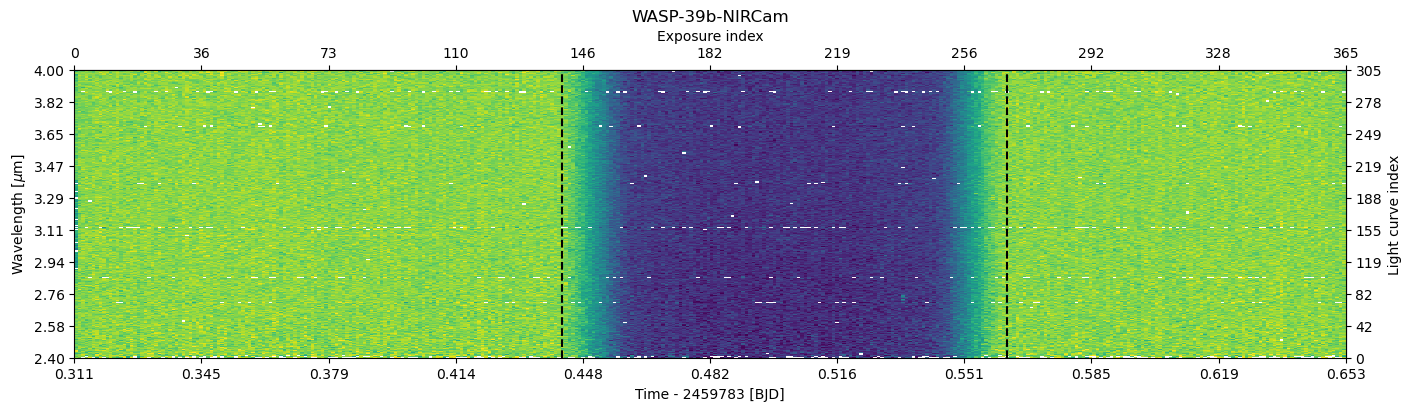

In [5]:
db = d.bin_wavelength(r=600, estimate_errors=True)
db.plot(plims=(0.1, 99.9));

Estimate the average uncertainties for each spectrophotometric light curve based on the out-of-transit data.

In [6]:
db.estimate_average_uncertainties()

## Initialise the analysis

In [7]:
ts = ExoIris('WASP-39b-NIRCam-wn', 'power-2', db, nk=100)

Next, we set up the priors. We can calculate the expected transit centre time for the observed epoch using the `Ephemeris.transit_center` method.

In [8]:
ts.set_prior('tc_00', 'NP', eph.transit_center(db.time.mean()), 0.003)  # Zero epoch for epoch group 0
ts.set_prior('p', 'NP', eph.period, 1e-5)                               # Orbital period
ts.set_prior('sigma_m_00', 'UP', 0.8, 2.0)                              # Uncertainty multiplier for noise group 0
ts.set_prior('bl_00_c', 'NP', 1.0, 0.001)                               # Baseline constant for data set 0
ts.set_radius_ratio_prior('UP', 0.14, 0.15)                             
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

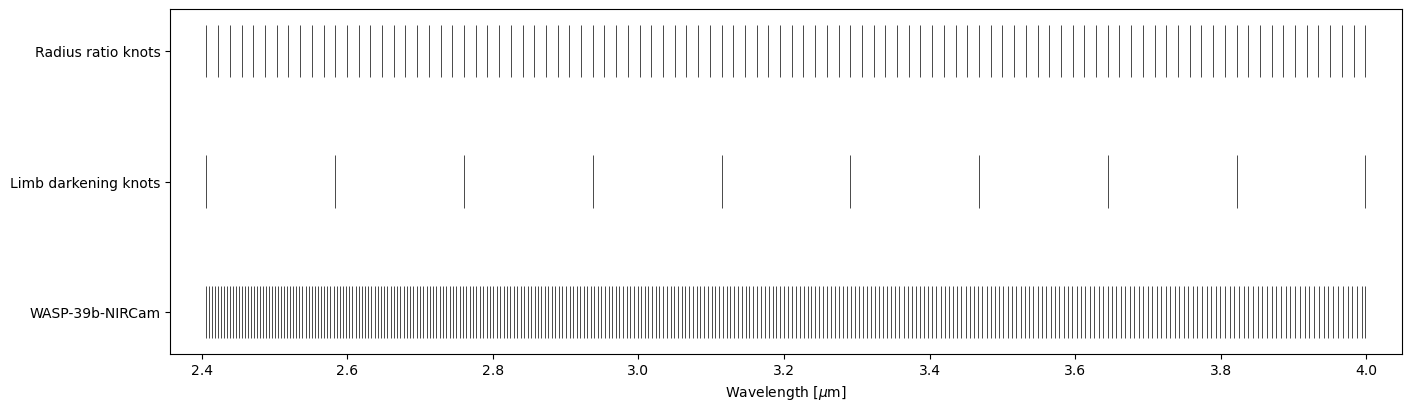

In [9]:
ts.plot_setup();

## Fit the white light curve

In [10]:
ts.fit_white()

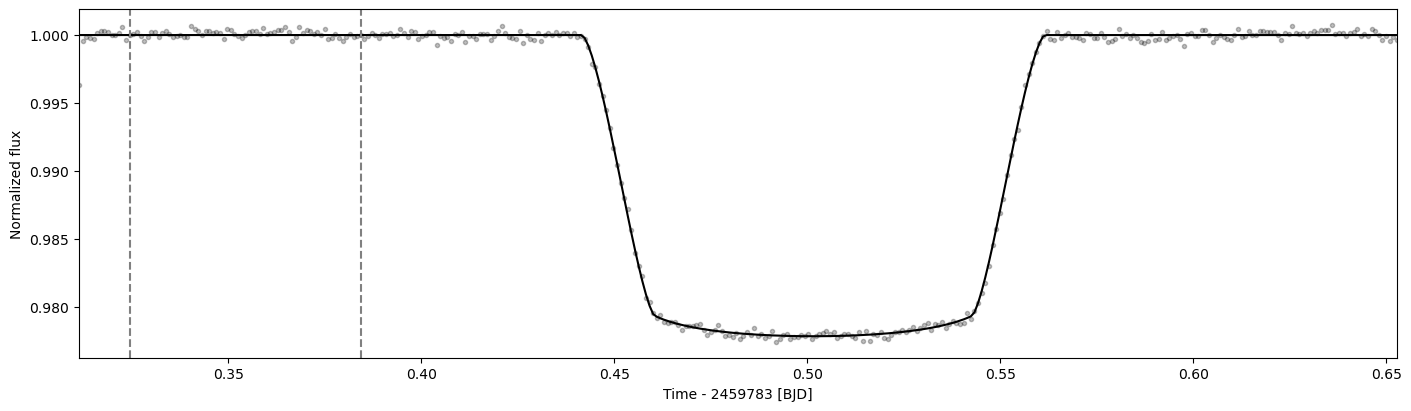

In [11]:
ts.plot_white(ncols=1);

In [12]:
ts.save(overwrite=True)

## Fit the transmission spectroscopy

In [13]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

In [14]:
ts.ndim

128

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

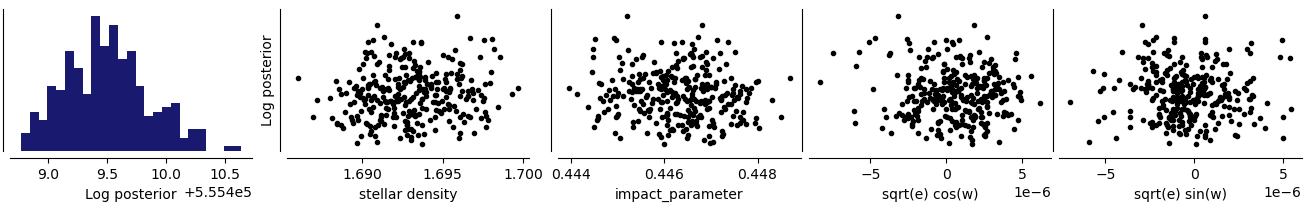

In [15]:
ts.fit(niter=2500, npop=300, pool=pool, lnpost=lnpostf)

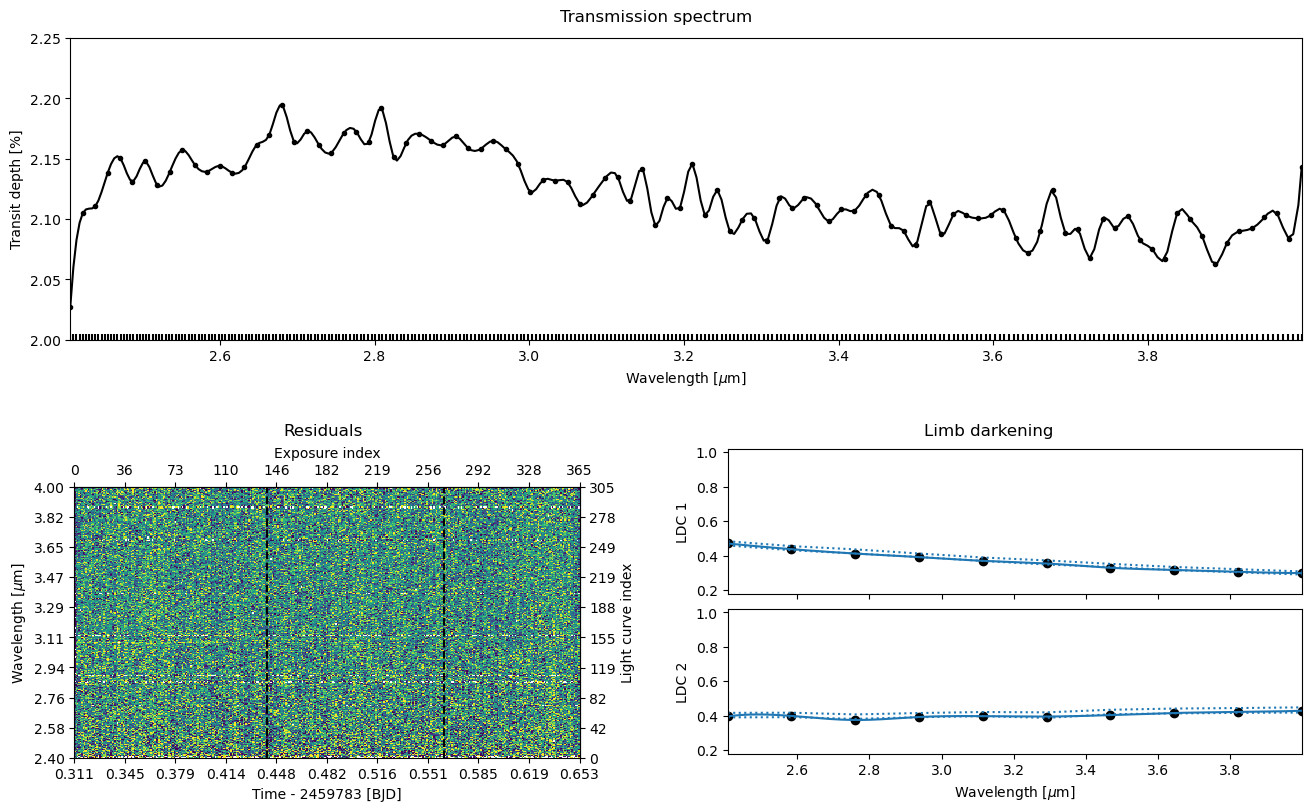

In [16]:
ts.plot_fit(result='fit', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.25)));

In [17]:
ts.save(overwrite=True)

## Sample the posterior

In [18]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

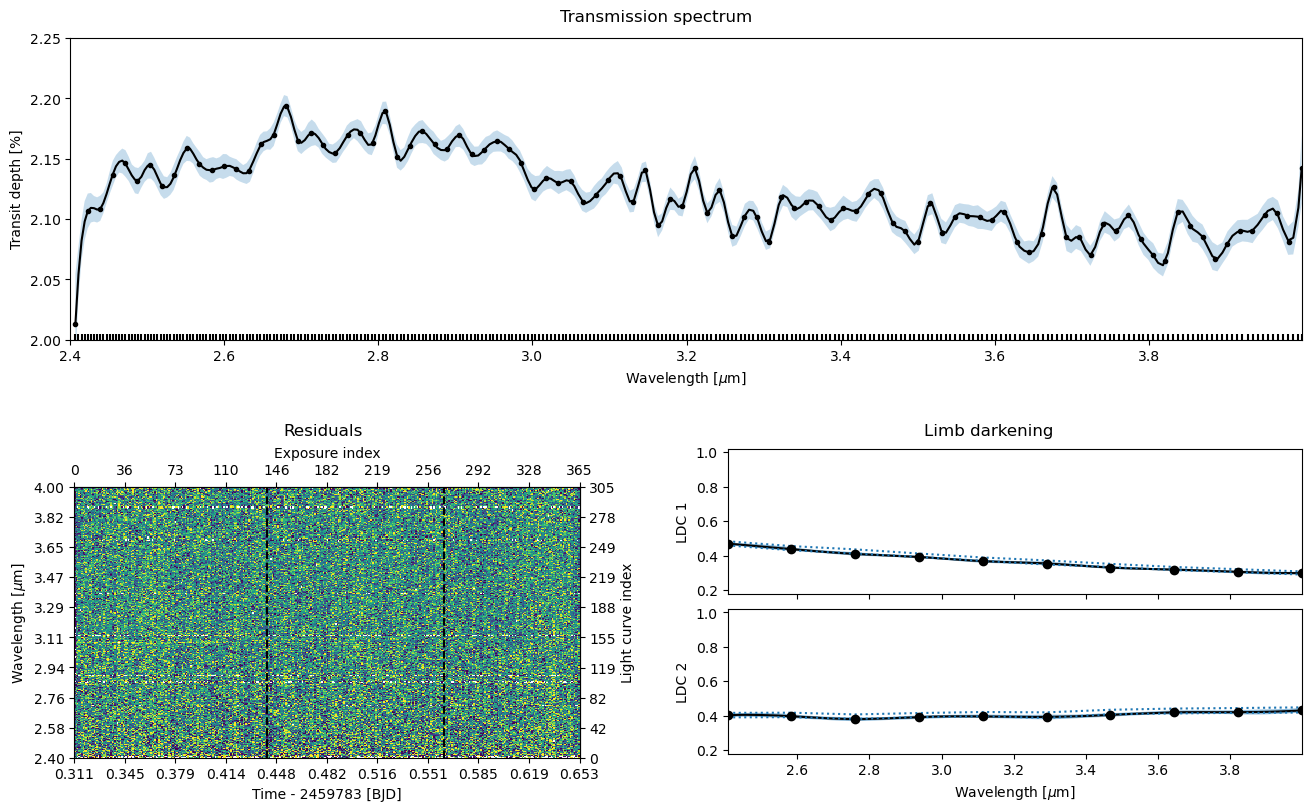

In [19]:
ts.plot_fit(result='mcmc', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.25), xticks=(2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8)));

In [20]:
ts.save()

In [21]:
pool.close()

---

<center>&copy;2025 Hannu Parviainen</center>